# Chatbot Skynet 2

<img src="./assets/images/logo.png" width="300" />

[Dialogflow](https://dialogflow.cloud.google.com) ist eine Platform mit der Chabots erstellt und bearbeitet werden können.   
<br><br>
Es bietete dabei eine Webobefläche mit der Inhalte des Chatbots erstellt und angepasst werden können.
Außerdem gibt es eine [Schnittstellenbibliothek](https://github.com/googleapis/python-dialogflow) für Python. Diese wurde auch in diesem Projekt zur Kommunikation mit Dialogflow verwendet.

## Anforderungen an den Chatbot
1. Führen von einfachen Smalltalk
2. Ermitteln und visualisieren von aktuellen Crypto-Preisen

## Setup am eigenen Rechner
1. Bei [Dialogflow](https://dialogflow.cloud.google.com) anmelden (Ein Google Konto ist dazu voraussetzung)
2. Einen neuen Agent auf Dialogflow anlegen<br><img src="./assets/images/screenshot_new_agent.png" width="300">
3. [Download Chatbot Template](assets/dialogflow/bot.zip) und in Dialogflow importieren.<br><img src="./assets/images/screenshot_import.png" width="300">
4. Dialogflow API [aktivieren](https://cloud.google.com/dialogflow/es/docs/quick/setup#api)
5. Auf Service-Account [anlegen](https://console.cloud.google.com/apis/credentials/serviceaccountkey) den Chatbot auswählen und einer neuen Rolle zuweisen.
6. Schlüsseldatei im Json-Format herunterladen und in den Orderner `keys` mit dem namen `./private_key.json` ablegen.

## Einbinden der benötigten Bibliotheken

In [416]:
import os # Setzen von Umgeungsvariablen
import json
import uuid # Erstellen von weltweit eindeutigen Ids (z.B: '92082417-1b45-4134-a6a7-a091cf54103f')
import requests # HTTP-Client zum Abfragen REST-Schnittstellen
import pandas as pd # Tabilarische Darstellung von Daten
import plotly.express as plotly # Darstellen von Graphen (z.B.: Krypto-Carts)
from google.cloud import dialogflow_v2 as df # Klassenbibliothek für Dialogflow Client

## Konstante Variablen definieren

In [417]:
# Lokale Dateipfad zu der Schlüsseldatei von Dialogflow
key_file_path='./keys/private_key.json'

# Schlüsseldatei wird in Umgebungsvariable gespeichert (Damit regelt die Dialogflow-Schnittstelle die Anmeldung)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_file_path
key_file = json.load(open(key_file_path))

# Die Projekt-Id von der Schlüsseldatei auslesen
project_id = key_file["project_id"]

# Weltweit eindeutige Id generieren. (Z.B: '92082417-1b45-4134-a6a7-a091cf54103f')
session_id = uuid.uuid4()
language_code = 'de'

## Benutzereingaben richtig erkennen
Im nächsten Codeblock wird eine Funktion entwickelt, welche die Absicht einer Texteingabe eines Benutzers ermittelt.

In [418]:
session_client = df.SessionsClient()

def detected_intent(text: str) -> df.DetectIntentResponse:
    session = session_client.session_path(project_id, session_id)
    text_input = df.TextInput(text=text, language_code=language_code)
    query_input = df.QueryInput(text=text_input)

    response = session_client.detect_intent(
        request = {
            'session': session,
            'query_input': query_input
        }
    )

    return response

Der Rückabewert der Funktion `detect_intent(text)` ist die Antwort von Dialogflow welche auf Basis der Benutzeranfrage ermittelt wurde.

### Beispiel-Aufruf 1
Der Benutzer sendet die Nachricht `"Hallo"` an den Chatbot (Dialogflow). Dialogflow liefert dabei folgende Daten.

In [419]:
detected_intent("Hallo")

response_id: "088dab9f-3da6-4ea1-93c5-563db1ecfadf-bd76d68e"
query_result {
  query_text: "Hallo"
  language_code: "de"
  action: "input.welcome"
  parameters {
  }
  all_required_params_present: true
  fulfillment_text: "Schönen Guten Tag!"
  fulfillment_messages {
    text {
      text: "Schönen Guten Tag!"
    }
  }
  intent {
    name: "projects/school-project-hwq9/agent/intents/b4660823-7f21-40de-af85-3cc9a3394ced"
    display_name: "Default Welcome Intent"
  }
  intent_detection_confidence: 1
}

Interesannt ist hierbei der `fullfillment_text`. Dort ist die Text-Antwort des Chabots enthalten. Dieser wert wird später vom Programm ermittelt und verwendet.

### Beispiel-Aufruf 2
Der Benutzer sendet die Nachricht `"Was ist der aktuelle Preis von Bitcoin"` an den Chatbot (Dialogflow). Die Rückgabe ist hierbei: 

In [420]:
detected_intent("Was ist der aktuelle Preis von Bitcoin")

response_id: "176d2b36-d9c0-48de-8fa7-6ae7545cd964-bd76d68e"
query_result {
  query_text: "Was ist der aktuelle Preis von Bitcoin"
  language_code: "de"
  parameters {
    fields {
      key: "crypto"
      value {
        string_value: "bitcoin"
      }
    }
  }
  all_required_params_present: true
  fulfillment_text: "Der aktuelle ${token_name} Preis ist ${token_price} Euro"
  fulfillment_messages {
    text {
      text: "Der aktuelle ${token_name} Preis ist ${token_price} Euro"
    }
  }
  intent {
    name: "projects/school-project-hwq9/agent/intents/de6767ea-bb74-4847-853e-4eb4a0200f07"
    display_name: "crypto_price"
  }
  intent_detection_confidence: 0.715235174
}

Hierbei sind der Ermittelte Crypto-Parameter mit dem ermittelten Wert `bitcoin` releveant. Damit kann das Programm später unterscheiden von welcher Crypto-Währung der Preis ermittelt werden soll.

### Beispiel-Aufruf 3
Im folgendem Beispiel wird vom Benutzer der Ethereum Preis abgefragt. Der Chatbot liefert hier folgende Antwort.

In [423]:
detected_intent("Ethereum Preis")

response_id: "c337b974-d010-4fa2-bd04-2e84b588d9e0-bd76d68e"
query_result {
  query_text: "kefkdfkjdkf Preis"
  language_code: "de"
  parameters {
    fields {
      key: "crypto"
      value {
        string_value: ""
      }
    }
  }
  all_required_params_present: true
  fulfillment_text: "Aktuell ist der Preis von ${token_name} ${token_price} Euro"
  fulfillment_messages {
    text {
      text: "Aktuell ist der Preis von ${token_name} ${token_price} Euro"
    }
  }
  intent {
    name: "projects/school-project-hwq9/agent/intents/de6767ea-bb74-4847-853e-4eb4a0200f07"
    display_name: "crypto_price"
  }
  intent_detection_confidence: 0.658652425
}

In diesem Fall ist der Crypt-Parameter-Wert `ethereum`.

## Erste Konversation mit dem Chatbot Skynet
Verwendung von einer Endlosschleife.

In [422]:
while True:
    text = input("You: ")
    if (text == 'quit'):
        break
    
    result = detected_intent(text)
    print(f'Bot: {result.query_result.fulfillment_text}')

KeyboardInterrupt: Interrupted by user

<b>Problem:</b> Hierbei können keine Kryptowährungen abgefragt werden.

## Aktueller Krypto-Preis von Schnittstelle abfragen

Für die Ermittlung des Preises der angebundenen Kryptowährungen wird die frei verfügbare Schnittstelle von [CoinGecko](https://www.coingecko.com/en/api/documentation) 
verwendet.<br>
<br>
<img src="./assets/images/coingecko_swagger.jpg" width="500">

Die Schnittstelle basiert auf REST (REpresentational State Transfer).
<br><br>
<img src="./assets/images/rest.jpg">  
[Quelle](https://www.opc-router.de/wp-content/uploads/2021/11/REST_Endpunkt_600x400px_1.png) vom Bild
<br><br>
REST ist eine Programmierschnittstelle, die einen Ansatz von Komunnikation zwischen Server und Client beschreibt. Dabei nutzt es zur Übertragung der Daten HTTP/S.   

In [ ]:
coin_id = 'bitcoin'
days = 3
response = requests.get(f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart?vs_currency=eur&days={days}&interval=daily")
response.json()

{'prices': [[1669593600000, 15872.19981187594],
  [1669680000000, 15683.633332537333],
  [1669766400000, 15928.168104093502],
  [1669824380000, 16416.474155514206]],
 'market_caps': [[1669593600000, 305283686999.67566],
  [1669680000000, 301463855559.4635],
  [1669766400000, 306322495858.3206],
  [1669824380000, 315627809140.33057]],
 'total_volumes': [[1669593600000, 15961567973.43568],
  [1669680000000, 23750463727.980415],
  [1669766400000, 23892315574.122288],
  [1669824380000, 24800778747.64632]]}

Die CoinGecko-Schnittstelle liefert hierbei ein JSON-Objekt. JSON (JavaScript Object Notation) ist ein kompaktes Datenformat, bei dem Werte in einem Key-Value-Format abgespeichert werden. Es eignet sich gut für den Datenaustausch zwichen Anwendungen.

### Funktion erstellen um Krypto-Preis zu ermitteln
Hierzu wird wie im obrigen Beispiel die Schnittstelle von CoinGecko aufgerufen.  
Außerdem werden die Werte mithilfe eines `padas.DataFrame` tabilarisiert.

In [ ]:
crypto_price_key = 'Preis'
crypto_volume_key = 'Volumen'
crypto_time_key = 'Datum'

def get_crypto_chart(coin_id: str, days) -> pd.DataFrame:
    response = requests.get(f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart?vs_currency=eur&days={days}&interval=daily").json()
    token_history = response['prices']
    token_volumes = response['total_volumes']

    price_frame = pd.DataFrame(token_history, columns = [crypto_time_key, crypto_price_key])
    volume_frame = pd.DataFrame(token_volumes, columns = [crypto_time_key, crypto_volume_key])

    result = price_frame.set_index(crypto_time_key).join(volume_frame.set_index(crypto_time_key)).reset_index()
    result[crypto_time_key]=(pd.to_datetime(result[crypto_time_key],unit='ms')) # Unit-Timestamp zu Datum konvertieren

    return result

#### Beispiele
Ermitteln des Bitcoin-Verlaufs der letzten 3 Tage + aktueller Tag

In [ ]:
get_crypto_chart('bitcoin', 3)

,Datum,Preis,Volumen
0,2022-11-28 00:00:00,15872.199812,1.596157e+10
1,2022-11-29 00:00:00,15683.633333,2.375046e+10
2,2022-11-30 00:00:00,15928.168104,2.389232e+10
3,2022-11-30 21:42:35,16385.521030,2.837873e+10


Ermitteln des Ethereum-Verlaufs der letzten 6 Tage + aktueller Tag

In [ ]:
get_crypto_chart('ethereum', 6)

,Datum,Preis,Volumen
0,2022-11-25 00:00:00,1156.942647,6.682519e+09
1,2022-11-26 00:00:00,1151.366666,5.591975e+09
2,2022-11-27 00:00:00,1157.672773,5.061311e+09
3,2022-11-28 00:00:00,1153.538666,4.002898e+09
4,2022-11-29 00:00:00,1131.267899,6.252560e+09
5,2022-11-30 00:00:00,1178.907158,6.910067e+09
6,2022-11-30 21:58:07,1246.737680,9.231308e+09


## Name von Kryptowährung ermitteln

Hierzu wird ebenfalls die REST-Schnittstelle von Coingecko aufgerufen. Diese liefert ebenfalss die Daten im JSON-Format. Hierbei ist aber nur der name Notwendig, deshalb wid mit `response.json()['name']` nur der name der Kryptowährung herausgelesen.

In [ ]:
def get_token_infos(coin_id: str):
    response = requests.get(f'https://api.coingecko.com/api/v3/coins/{coin_id}?tickers=false&market_data=false&community_data=false&developer_data=false&sparkline=false').json()
    name =  response['name']
    image_url = response['image']['small']
    return (name, image_url)

#### Beispiel

In [ ]:
print(get_token_infos('bitcoin'))
print(get_token_infos('ethereum'))

Bitcoin
('Bitcoin', 'https://assets.coingecko.com/coins/images/1/small/bitcoin.png?1547033579')
Ethereum
('Ethereum', 'https://assets.coingecko.com/coins/images/279/small/ethereum.png?1595348880')


## Rückgabe von Dialogflow verarbeiten

Zuerst wird ein Klasse definiert, welche Eigenschaften (Attribute) enthält.  
Die Eigenschaften sind dabei auf ihrem Anwedungszweck ausgerichtet.

In [ ]:
class ChatbotCryptoResult:
    def __init__(self, data_frame, token_name, token_image_url) -> None:
        self.data_frame = data_frame
        self.token_name = token_name
        self.token_image_url = token_image_url

    data_frame: pd.DataFrame = None
    token_name: str = None
    token_image_url: str = None

class ChatbotResultMessage:
    text_result: str = None
    crypto_result: ChatbotCryptoResult = None

In der folgenden Methode `parse_intent_response(intent_response)` werden aus der Rückgabe von Dialgoflow die benötigten werte gelesen und verarbeitet.

In [424]:
def parse_intent_response(intent_response: df.DetectIntentResponse) -> ChatbotResultMessage:
    query_result : df.QueryResult = intent_response.query_result

    text = query_result.fulfillment_text
    ret = ChatbotResultMessage()
    ret.text_result = text

    intent_name = query_result.intent.display_name

    if intent_name == 'crypto_price':
        coin_id = query_result.parameters['crypto']

        if coin_id == '' or coin_id is None:
            ret.text_result = 'Kryptowährung konnte nicht ermittelt werden.'
        else:
            token_name, token_image_url = get_token_infos(coin_id)
            chart_df = get_crypto_chart(coin_id, 365)
            current_price = "%.2f" % chart_df.iloc[-1][crypto_price_key]

            ret.crypto_result = ChatbotCryptoResult(
                data_frame = chart_df,
                token_name = token_name, 
                token_image_url = token_image_url
            )

            ret.text_result = ret.text_result.replace('${token_name}', token_name)
            ret.text_result = ret.text_result.replace('${token_price}', current_price)

    return ret

Als erstes ermittelt die Methode den Antwort-Text des Chatbots und schreibt diesen in das Result-Objekt.

Anschließend wird der Preisverlauf und der Name der Kryptowährung ermittelt, falls es sich um eine diesbezügliche Abfrage handelt. Die Ergebnisse werden dann auch in das Result-Objekt gespeichert. 

<p float="left">
    <img src="./assets/images/screenshot_dialogflow_parameters.png" width="500">
    <img src="./assets/images/screenshot_dialogflow_fullfilment_text.png" width="500">
</p>

## Ausgabe in Konsole
1. (Falls vorhanden) Text-Antwort ausgeben
2. (Falls vorhanden) Krypto-Preisverlauf in Diagramm visualisiern

In [ ]:
# from PIT import Image

def print_result_to_console(chatbot_result: ChatbotResultMessage):
    crypto_result = result.crypto_result

    if result.text_result is not None:
        print(f"Bot: {result.text_result}")

    if crypto_result is not None:
        
        token_img = Image.open(requests.get(crypto_result.token_image_url, stream=True).raw)
        display(token_img)
        fig = plotly.line(crypto_result.data_frame, x=crypto_time_key, y=crypto_price_key, title=f'Preisverlauf von {crypto_result.token_name}')
        fig.update_xaxes(rangeslider_visible=True)
        fig.show()

## Finale Ausgabe der Abfrage
1. Ermitteln der Benutzerabsicht
2. Verabeiten der Dialogflow response
3. Antwort des Chatbots in Konsole ausgeben

Bot: Der aktuelle Bitcoin Preis ist 16404.58 Euro


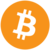

In [426]:
detect_intent_result = detected_intent("Was ist der aktuelle bitcoin preis")
result = parse_intent_response(detect_intent_result)
print_result_to_console(result)

# Und jetzt alles zusammen

In [ ]:
while True:
    text = input('You: ')
    if (text == 'quit'):
        break

    detect_intent_result = detected_intent(text)
    result = parse_intent_response(detect_intent_result)
    print_result_to_console(result)
    print('_'*50)

## Entity Types auf Dialogflow anlegen 

In [ ]:
class CoinDto:
    def __init__(self: str, id: str, symbol, name: str):
        self.id = id
        self.symbol = symbol
        self.name = name


    id: str = None
    symbol: str = None
    name: str = None

In [ ]:
def get_coin_list():
    # result = requests.get('https://api.coingecko.com/api/v3/coins/list').json()
    result = requests.get('https://api.coingecko.com/api/v3/coins/markets?vs_currency=Eur&order=market_cap_desc&per_page=100&page=1&sparkline=false').json()
    ret = [CoinDto(r['id'], r['symbol'], r['name']) for r in result]
    return ret 

In [ ]:
client = df.EntityTypesClient()
entity_client = df.EntityTypesClient()
parent_path = f'projects/{project_id}/locations/global/agent'
entity_name = 'crypto'
entity_type_id = '218b9247-814b-4e2b-84da-bf748ae608f6'
entity_type_path = client.entity_type_path(project_id, entity_type_id)

In [ ]:
def get_entity_type_names():
    request = df.GetEntityTypeRequest()
    request.language_code = language_code
    request.name = entity_type_path

    result = client.get_entity_type(request)
    ret = [x.value for x in result.entities]
    
    return ret

get_entity_type_names()

['01coin',
 '0-5x-long-algorand-token',
 '0-5x-long-altcoin-index-token',
 '0-5x-long-bitcoin-token',
 '0-5x-long-cardano-token',
 '0-5x-long-chainlink-token',
 '0-5x-long-dogecoin-token',
 '0-5x-long-eos-token',
 '0-5x-long-ethereum-classic-token',
 '0-5x-long-ethereum-token',
 '0-5x-long-kyber-network-token',
 '0-5x-long-matic-token',
 '0-5x-long-privacy-index-token',
 '0-5x-long-swipe-token',
 '0chain',
 '0x',
 '0xcert',
 '0xdao',
 '0xdao-v2',
 '0xmonero',
 '0xpad',
 '0xtrade',
 '0xwallet-token',
 '100-days-ventures',
 '10604-somerset',
 '10612-somerset',
 '10617-hathaway',
 '10mb',
 '10share',
 '11078-wayburn',
 '11300-roxbury',
 '11653-nottingham',
 '11957-olga',
 '12334-lansdowne',
 '12405-santa-rosa',
 '1244-s-avers',
 '12866-lauder',
 '12ships',
 '13045-wade',
 '13114-glenfield',
 '1337',
 '14066-santa-rosa',
 '14078-carlisle',
 '14231-strathmoor',
 '14319-rosemary',
 '14882-troester',
 '15039-ward',
 '1542-s-ridgeway',
 '15777-ardmore',
 '15860-hartwell',
 '1617-s-avers',
 '17

In [377]:
# entity_type_names = get_entity_type_names()

# request = df.BatchDeleteEntityTypesRequest()
# request.parent = parent_path
# request.entity_type_names = entity_type_names

# client.batch_delete_entity_types(request)

In [ ]:
request = df.CreateEntityTypeRequest()
request.language_code = language_code
request.parent = parent_path

entity_type = df.EntityType()
entity_type.display_name = entity_name
entity_type.kind = entity_type.Kind.KIND_MAP
entity_type.entities = []

coins = get_coin_list()

for i in range(len(coins)):
    coin = coins[i]

    entity = entity_type.Entity()
    entity.synonyms = [coin.id, coin.name, coin.symbol]
    entity.value = coin.id

    entity_type.entities.append(entity)
 
request.entity_type = entity_type

entity_client.create_entity_type(request=request)

FailedPrecondition: 400 com.google.apps.framework.request.FailedPreconditionException: This entity's displayName 'crypto' already exists with current agent. Code: FAILED_PRECONDITION